# Asignación de unidades

**Contribución de**: Uriel Sandoval

Esta notebook contiene la implementación del problema de asignación de unidades en el lenguaje Julia.

Para ejecutar los comandos los siguientes paquetes de Julia son necesarios:


* [JuMP](https://jump.dev/)  
* [GLPK](https://osqp.org/): Solver para problemas lineales y con variables enteras.

Los paquetes pueden ser instalados de la siguiente forma:

```Julia
import Pkg;
Pkg.add(["JuMP", "GLPK"])
```

El ejemplo es una traducción del [libro de "Power System Optimization Modeling in GAMS. Springer, 2017"](https://www.gams.com/latest/psoptlib_ml/libhtml/psoptlib_UC.html)



Empezamos importando los paquetes necesarios

In [1]:
using JuMP, GLPK;
using DataFrames;
using CSV;
using Plots;
plotly();

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /Users/urielsandoval/.julia/packages/Plots/vsE7b/src/backends.jl:372


In [2]:
ord(t, T) = findfirst(isequal(t), T);



G = ["g$i" for i in 1:10];
K = ["sg$i" for i in 1:10];
T = ["t$i" for i in 1:24];


df = CSV.read(IOBuffer("""
i    a      b     c    CostsD  costst  RU   RD   UT  DT  SD   SU   Pmin Pmax U0 Uini S0
g1   0.0148 12.1  82   42.6    42.6    40   40   3   2   90   110  80   200  1  0    1
g2   0.0289 12.6  49   50.6    50.6    64   64   4   2   130  140  120  320  2  0    0
g3   0.0135 13.2  100  57.1    57.1    30   30   3   2   70   80   50   150  3  0    3
g4   0.0127 13.9  105  47.1    47.9    104  104  5   3   240  250  250  520  1  1    0
g5   0.0261 13.5  72   56.6    56.9    56   56   4   2   110  130  80   280  1  1    0
g6   0.0212 15.4  29   141.5  141.5    30   30   3   2   60   80   50   150  0  0    0
g7   0.0382 14.0  32   113.5  113.5    24   24   3   2   50   60   30   120  0  1    0
g8   0.0393 13.5  40   42.6    42.6    22   22   3   2   45   55   30   110  0  0    0
g9   0.0396 15.0  25   50.6    50.6    16   16   0   0   35   45   20   80   0  0    0
g10  0.0510 14.3  15   57.1    57.1    12   12   0   0   30   40   20   60   0  0    0
"""), DataFrame,  delim=" ", ignorerepeated=true, copycols=true);



df2 = CSV.read(IOBuffer("""
t    lambda  load
t1   14.72   883
t2   15.62   915
t3   14.72   1010
t4   14.73   1149
t5   14.83   1236
t6   15.72   1331
t7   20.21   1397
t8   23.40   1419
t9   23.86   1455
t10  21.27   1455
t11  19.83   1441
t12  17.38   1419
t13  17.96   1397
t14  17.75   1339
t15  18.51   1368
t16  17.65   1339
t17  23.45   1236
t18  18.38   1105
t19  18.54   1038
t20  18.52   959
t21  20.59   922
t22  20.52   885
t23  20.50   915
t24  15.62   834
"""), DataFrame,  delim=" ", ignorerepeated=true, copycols=true);

# Convert dataframes to dict
cols = filter!(e->e≠"i", names(df))
gendata = Dict{String, Dict}();
[gendata[x] = Dict([(col, df[df.i .== x, col][1]) for col in cols]) for x in df.i];

cols = filter!(e->e≠"t", names(df2))
dataLP = Dict{String, Dict}();
[dataLP[x] = Dict([(col, df2[df2.t .== x, col][1]) for col in cols]) for x in df2.t];

## Linealizar la función de costo incremental

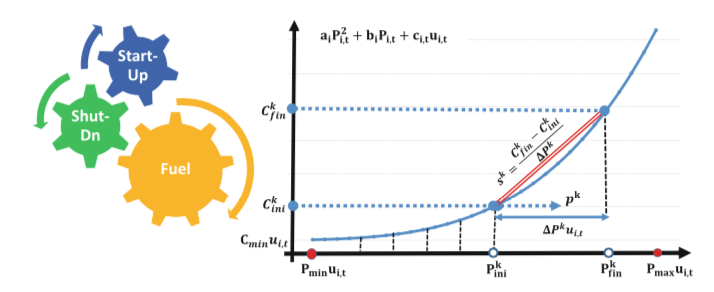


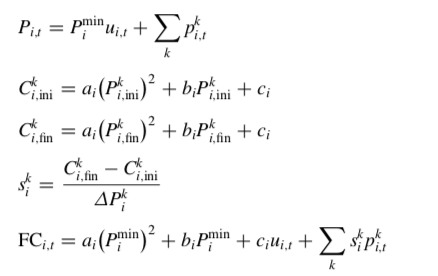


In [3]:
labels = ["DP", "Pini", "Pfin", "Cini", "Cfin", "s", "Mincost"];

data = Dict(zip(collect(Iterators.product(K, G, labels)),
                zeros(length(K) * length(G) * length(labels))));

for (k, i) in Iterators.product(K, G)
    data[(k, i, "DP")] = (gendata[i]["Pmax"] -
                          gendata[i]["Pmin"]) / length(K);

    data[(k, i, "Pini")] = (ord(k, K) - 1) * data[(k, i, "DP")] + gendata[i]["Pmin"];

    data[(k, i, "Pfin")] = data[(k, i, "DP")] + data[(k, i, "Pini")];

    data[(k, i, "Cini")] = gendata[i]["a"] * data[(k, i, "Pini")]^2 +
                           gendata[i]["b"] * data[(k, i, "Pini")] +
                           gendata[i]["c"];

    data[(k, i, "Cfin")] = gendata[i]["a"] * data[(k, i, "Pfin")]^2 +
                          gendata[i]["b"] * data[(k, i, "Pfin")] +
                          gendata[i]["c"];

    data[(k, i, "s")] = (data[(k, i, "Cfin")] - data[(k, i, "Cini")]) / data[(k, i, "DP")];
end


for i in G
    gendata[i]["Mincost"] = gendata[i]["a"] * gendata[i]["Pmin"]^2 +
                            gendata[i]["b"] * gendata[i]["Pmin"] +
                            gendata[i]["c"];

    gendata[i]["Lj"] = min(length(T), (gendata[i]["UT"] - gendata[i]["U0"]) *
                                      gendata[i]["Uini"] *
                                      (gendata[i]["U0"] < gendata[i]["UT"]));
    gendata[i]["Fj"] = min(length(T), (gendata[i]["DT"] - gendata[i]["S0"]) *
                                      (1 - gendata[i]["Uini"]) *
                                      (gendata[i]["S0"] < gendata[i]["DT"]));
end

In [4]:
mod = Model(GLPK.Optimizer);


@variables(mod, begin
    0 <= pu[i in G, T] <= gendata[i]["Pmax"]
    0 <= p[i in G, T] <= gendata[i]["Pmax"]
    0 <= Pk[i in G, T, k in K] <= data[(k, i, "DP")]
    u[G, T], Bin
    y[G, T], Bin
    z[G, T], Bin
end
);

In [5]:
@expression(mod, StC[i in G, t in T], gendata[i]["costst"] * y[i,t]);
@expression(mod, SDC[i in G, t in T], gendata[i]["CostsD"] * z[i,t]);

@expression(mod, hour_cost[t in T], sum(StC[i, t] + SDC[i, t] +
                                        u[i,t] * gendata[i]["Mincost"] +
                                        sum(data[(k, i, "s")] * Pk[i,t,k] for k in K) for i in G));

@objective(mod, Min, sum(hour_cost[t] for t in T));

@constraint(mod, genconst1[i in G, t in T], p[i, t] == u[i,t] * gendata[i]["Pmin"] + sum(Pk[i,t,k] for k in K));

@constraint(mod, genconst2[i in G, t in T],
            u[i, t] == (ord(t, T) > 1 ? u[i, T[ord(t, T)-1]] : 0) +
                       (ord(t, T) == 1 ? gendata[i]["Uini"] : 0) +  y[i, t] - z[i, t]);


@constraint(mod, genconst3[i in G, t in T, k in K],
                 Pk[i, t, k] <=  u[i,t] * data[(k, i, "DP")]);

@constraint(mod, balance[t in T], sum(p[i,t] for i in G) == dataLP[t]["load"]);


# Ramp constraints
@constraint(mod, ramp1[i in G, t in T[2:end]],
                p[i, T[ord(t, T)-1]] - p[i, t] <=
                u[i,t] * gendata[i]["RD"] + z[i,t] * gendata[i]["SD"]);

# Pg <= Pmax(t)
@constraint(mod, ramp2[i in G, t in T], p[i, t] <= pu[i,t]);

@constraint(mod, ramp4[i in G, t in T[2:end]],
                pu[i, t] <=
                p[i, T[ord(t, T) - 1]] + u[i, T[ord(t, T) - 1]] * gendata[i]["RU"] +
                y[i, t] * gendata[i]["SU"]);

@constraint(mod, ramp3[i in G, t in T[1:end-1]],
                pu[i, t] <= gendata[i]["Pmax"] * (u[i,t] - z[i, T[ord(t, T) + 1]]) +
                            z[i, T[ord(t, T) + 1]] * gendata[i]["SD"]);


@constraint(mod, upTime1[i in G; gendata[i]["Lj"] > 0],
            sum(1 - u[i,t] for t in T[1:gendata[i]["Lj"]]) == 0)


@constraint(mod, downTime1[i in G; gendata[i]["Fj"] > 0],
            sum(u[i,t] for t in T[1:gendata[i]["Fj"]]) == 0)


upTime2 = []
upTime3 = []
downTime2 = []
downTime3 = []


for i in G

    if gendata[i]["UT"] >= 1
        for k in T[(gendata[i]["Lj"] + 1) : (end - gendata[i]["UT"] +1)]
            push!(upTime2,
                  @constraint(mod, sum(u[i,t] for t in T[ord(k, T): ord(k, T) + gendata[i]["UT"] - 1]) >= gendata[i]["UT"] * y[i, k]))
            if i == "g4"
            end
        end
    end

    if gendata[i]["UT"] >= 2
        for k in T[(end - gendata[i]["UT"] + 2):end]
            push!(upTime3,
                  @constraint(mod, sum(u[i,t] - y[i,k] for t in T[ord(k, T):end]) >= 0));
        end
    end


    if gendata[i]["DT"] >= 1
        for k in T[(gendata[i]["Fj"] + 1) : (end - gendata[i]["DT"] +1)]
            push!(downTime2,
                  @constraint(mod, sum(1 - u[i,t] for t in T[ord(k, T) : ord(k, T) + gendata[i]["DT"] - 1]) >= gendata[i]["DT"] * z[i, k]));

        end
    end

    if gendata[i]["DT"] >= 2
        for k in T[(end - gendata[i]["DT"] + 2):end]
            push!(downTime3,
                  @constraint(mod, sum(1 - u[i,t] - z[i,k] for t in T[ord(k, T):end]) >= 0));
        end
    end

end

(gendata[i])["Lj"] = 0
(gendata[i])["Lj"] = 0
(gendata[i])["Lj"] = 0
(gendata[i])["Lj"] = 4
(gendata[i])["Lj"] = 3
(gendata[i])["Lj"] = 0
(gendata[i])["Lj"] = 3
(gendata[i])["Lj"] = 0


In [6]:
optimize!(mod)

In [7]:
print(termination_status(mod))
if termination_status(mod) in (MOI.OPTIMAL, MOI.LOCALLY_SOLVED)
    @info("Updating variables")
    println("Objective cost ", objective_value(mod));



    for i in G, t in T

        fix(u[i, t], value.(u)[i, t])
        unset_binary(u[i,t]);

        fix(y[i, t], value.(y)[i, t])
        unset_binary(y[i,t]);

        fix(z[i, t], value.(z)[i, t])
        unset_binary(z[i,t]);

    end


    optimize!(mod)
end

OPTIMAL

┌ Info: Updating variables
└ @ Main In[7]:3


Objective cost 485301.769599999


In [9]:
plot(

    plot(transpose(hcat(value.(p))), title="Potencias de generación", ylabel="MW"),
    plot([dataLP[t]["load"] for t in T], linetype=:steppre, title="Demanda del sistema", ylabel="MW"),
    plot(hcat(value.(hour_cost)), title="Costo de producción horario", ylabel="\$/MWh"),
    plot(hcat(dual.(balance)), title="Precio Marginal Local", xlabel="Hora", ylabel="\$/MWh"),
    layout = (4,1),
    size=(800, 600)
)


<!DOCTYPE html>
 
 
 Plots.jl